# Bouncing Pendulum

This example demonstrates a hybrid system combining continuous pendulum dynamics with discrete bounce events. The pendulum swings until it hits the ground (zero angle), at which point it bounces back with reduced energy.

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/examples_event/example_bouncing_pendulum.py).

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import Integrator, Amplifier, Function, Adder, Scope
from pathsim.solvers import RKCK54
from pathsim.events import ZeroCrossing

## System Dynamics

The mathematical pendulum is governed by the nonlinear differential equation:

$$\ddot{\phi} = -\frac{g}{l} \sin(\phi)$$

where:
- $\phi$ is the angle from vertical
- $g$ is gravitational acceleration
- $l$ is the pendulum length

The bounce event occurs when $\phi = 0$ (pendulum hits the ground), at which point the angular velocity reverses with a loss factor.

In [3]:
# Initial angle and angular velocity
phi0, omega0 = 0.99*np.pi, 0.0

# Parameters (gravity, length)
g, l = 9.81, 1

# Bounceback coefficient
b = 0.9

## Block Diagram Construction

We construct the system from basic blocks:

In [4]:
# Blocks that define the system
In1 = Integrator(omega0)  # angular acceleration -> angular velocity
In2 = Integrator(phi0)    # angular velocity -> angle
Amp = Amplifier(-g/l)     # gravity term
Fnc = Function(np.sin)    # nonlinearity
Sco = Scope(labels=[r"$\omega$", r"$\phi$"])

blocks = [In1, In2, Amp, Fnc, Sco]

# Connections between the blocks
connections = [
    Connection(In1, In2, Sco[0]),
    Connection(In2, Fnc, Sco[1]),
    Connection(Fnc, Amp),
    Connection(Amp, In1)
]

In [5]:
# Event function for zero crossing detection
def func_evt(t):
    *_, ph = In2()
    return ph

# Action function for state transformation
def func_act(t):
    *_, om = In1()
    *_, ph = In2()
    In1.engine.set(-om*b)  # reverse velocity with energy loss
    In2.engine.set(abs(ph))  # ensure angle stays positive

# Events (zero crossing)
E1 = ZeroCrossing(
    func_evt=func_evt,
    func_act=func_act,
    tolerance=1e-6
)

events = [E1]

In [6]:
# Simulation instance from the blocks and connections
Sim = Simulation(
    blocks,
    connections,
    events,
    dt=0.1,
    log=True,
    Solver=RKCK54,
    tolerance_lte_abs=1e-8,
    tolerance_lte_rel=1e-6
)

11:30:10 - INFO - LOGGING (log: True)
11:30:10 - INFO - BLOCKS (total: 5, dynamic: 2, static: 3, eventful: 0)
11:30:10 - INFO - GRAPH (nodes: 5, edges: 6, alg. depth: 3, loop depth: 0, runtime: 0.118ms)


Now let's run the simulation:

In [7]:
Sim.run(duration=15)

11:30:12 - INFO - STARTING -> TRANSIENT (Duration: 15.00s)
11:30:12 - INFO - --------------------   1% | 0.0s<0.1s | 1490.5 it/s
11:30:12 - INFO - ####----------------  20% | 0.0s<0.1s | 1331.9 it/s
11:30:12 - INFO - ########------------  40% | 0.1s<0.0s | 7186.0 it/s
11:30:12 - INFO - ############--------  60% | 0.1s<0.0s | 7882.0 it/s
11:30:12 - INFO - ################----  80% | 0.1s<0.0s | 8378.1 it/s
11:30:12 - INFO - #################### 100% | 0.1s<--:-- | 7147.6 it/s
11:30:12 - INFO - FINISHED -> TRANSIENT (total steps: 327, successful: 254, runtime: 87.71 ms)


{'total_steps': 327, 'successful_steps': 254, 'runtime_ms': 87.70729205571115}

## Results

Let's plot the angular velocity and angle over time, marking the bounce events:

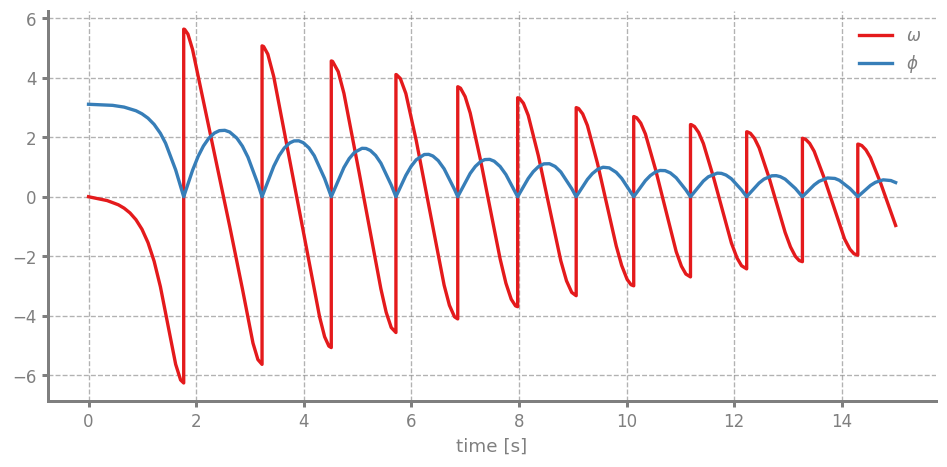

In [8]:
# Plot the results directly from the scope
fig, ax = Sco.plot(lw=2)

plt.show()

The plot shows:
- The angle oscillates between 0 and some maximum value that decreases over time
- The angular velocity reverses sign at each bounce (vertical dashed lines)
- Energy is progressively lost with each bounce, leading to smaller oscillations